# Load Data & GPU Config

In [1]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# List available physical devices
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Allow memory growth to avoid consuming all GPU memory
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU is being used")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

Num GPUs Available:  1
GPU is being used


In [2]:
train_dataset = tf.data.Dataset.load('train_dataset')
val_dataset = tf.data.Dataset.load('val_dataset')
test_dataset = tf.data.Dataset.load('test_dataset')

# Model

In [3]:
from keras import layers, models

# Set a random seed for reproducibility
tf.random.set_seed(42)

## 2D

In [4]:
def resnet_block(input, filters, strides=1):
    x = layers.Conv2D(filters, kernel_size=3, strides=strides, padding='same', use_bias=False)(input)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if strides != 1 or input.shape[-1] != filters:
        input = layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same', use_bias=False)(input)
        input = layers.BatchNormalization()(input)

    x = layers.add([x, input])
    x = layers.ReLU()(x)
    return x

def resnet18(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = resnet_block(x, 64)
    x = resnet_block(x, 64)

    x = resnet_block(x, 128, strides=2)
    x = resnet_block(x, 128)

    x = resnet_block(x, 256, strides=2)
    x = resnet_block(x, 256)

    x = resnet_block(x, 512, strides=2)
    x = resnet_block(x, 512)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

In [5]:
input_shape = (128, 128, 3)  # Modify based on your data shape
num_classes = 1  # Modify based on your number of classes

model = resnet18(input_shape=input_shape, num_classes=num_classes)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   9408        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [7]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20
)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc}")

Epoch 1/20
198/198 [==============================] - 22s 77ms/step - loss: 0.1697 - accuracy: 0.9446 - val_loss: 1.9004 - val_accuracy: 0.5196
Epoch 2/20
198/198 [==============================] - 13s 67ms/step - loss: 0.0811 - accuracy: 0.9704 - val_loss: 0.1158 - val_accuracy: 0.9582
Epoch 3/20
198/198 [==============================] - 13s 66ms/step - loss: 0.0498 - accuracy: 0.9831 - val_loss: 0.1254 - val_accuracy: 0.9506
Epoch 4/20
198/198 [==============================] - 13s 65ms/step - loss: 0.0379 - accuracy: 0.9867 - val_loss: 0.1544 - val_accuracy: 0.9544
Epoch 5/20
198/198 [==============================] - 13s 64ms/step - loss: 0.0275 - accuracy: 0.9910 - val_loss: 1.2748 - val_accuracy: 0.5361
Epoch 6/20
198/198 [==============================] - 13s 64ms/step - loss: 0.0273 - accuracy: 0.9905 - val_loss: 0.1123 - val_accuracy: 0.9708
Epoch 7/20
198/198 [==============================] - 13s 64ms/step - loss: 0.0225 - accuracy: 0.9922 - val_loss: 0.0503 - val_accuracy:

Layer: conv2d


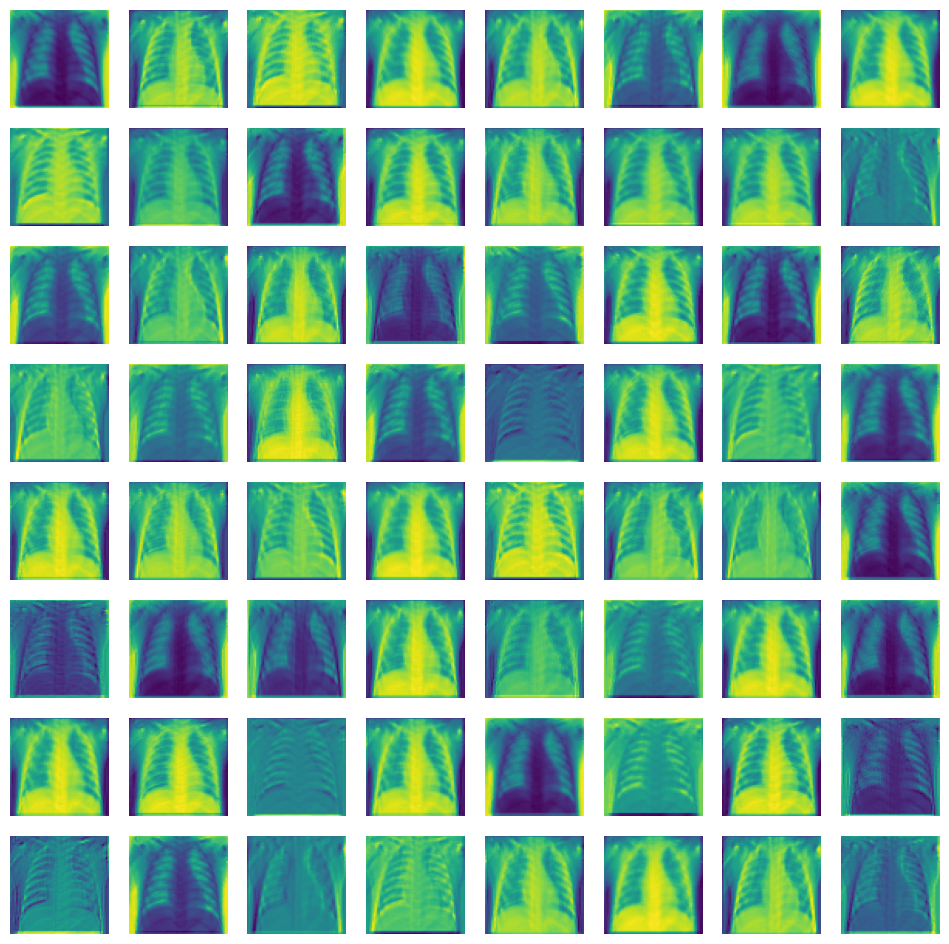

Layer: max_pooling2d


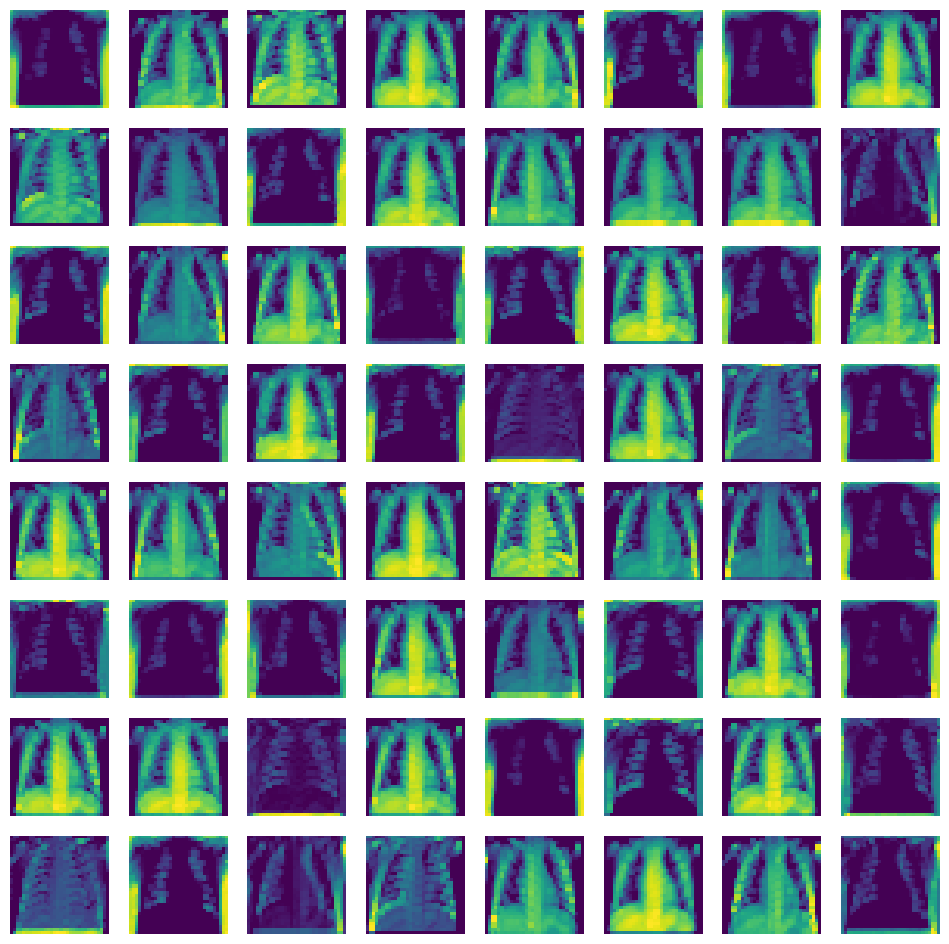

Layer: conv2d_1


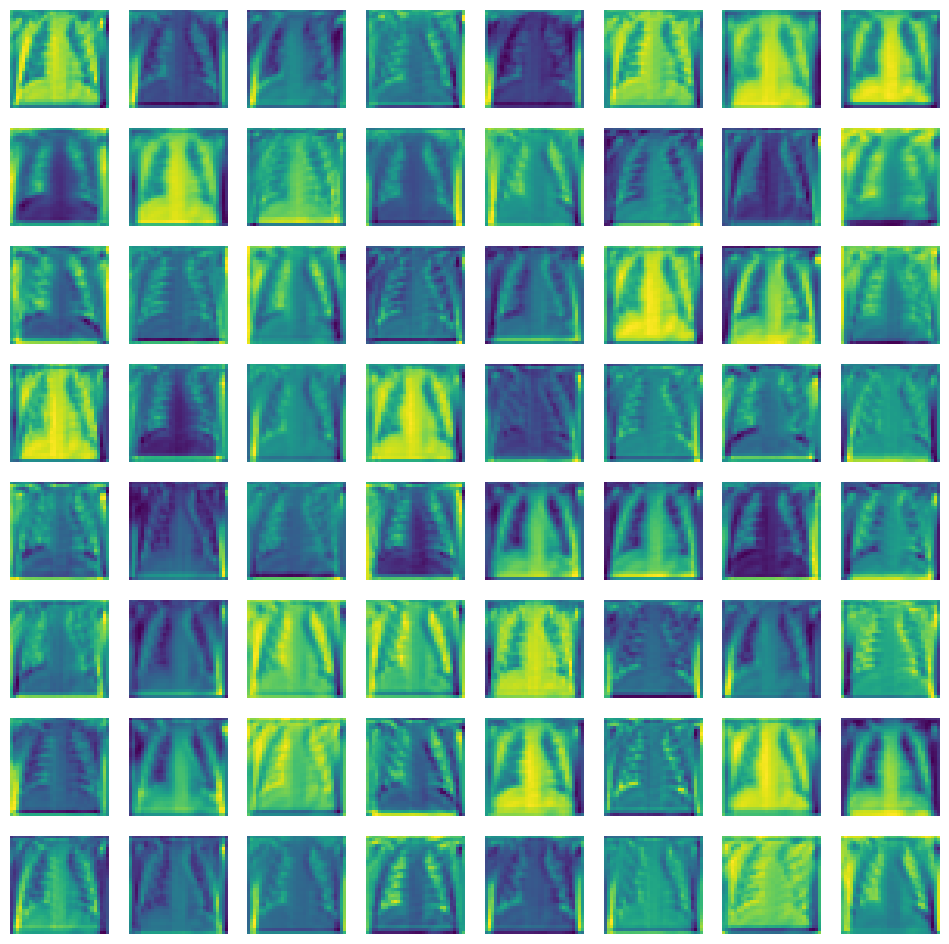

Layer: conv2d_2


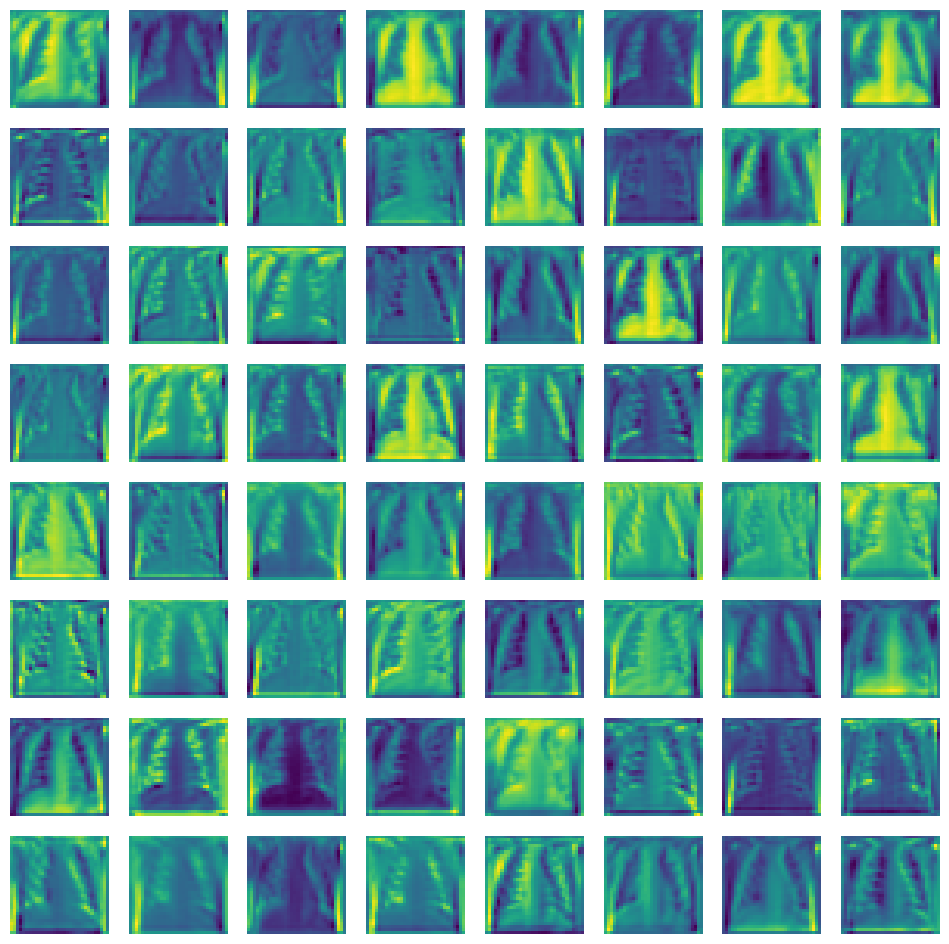

Layer: conv2d_3


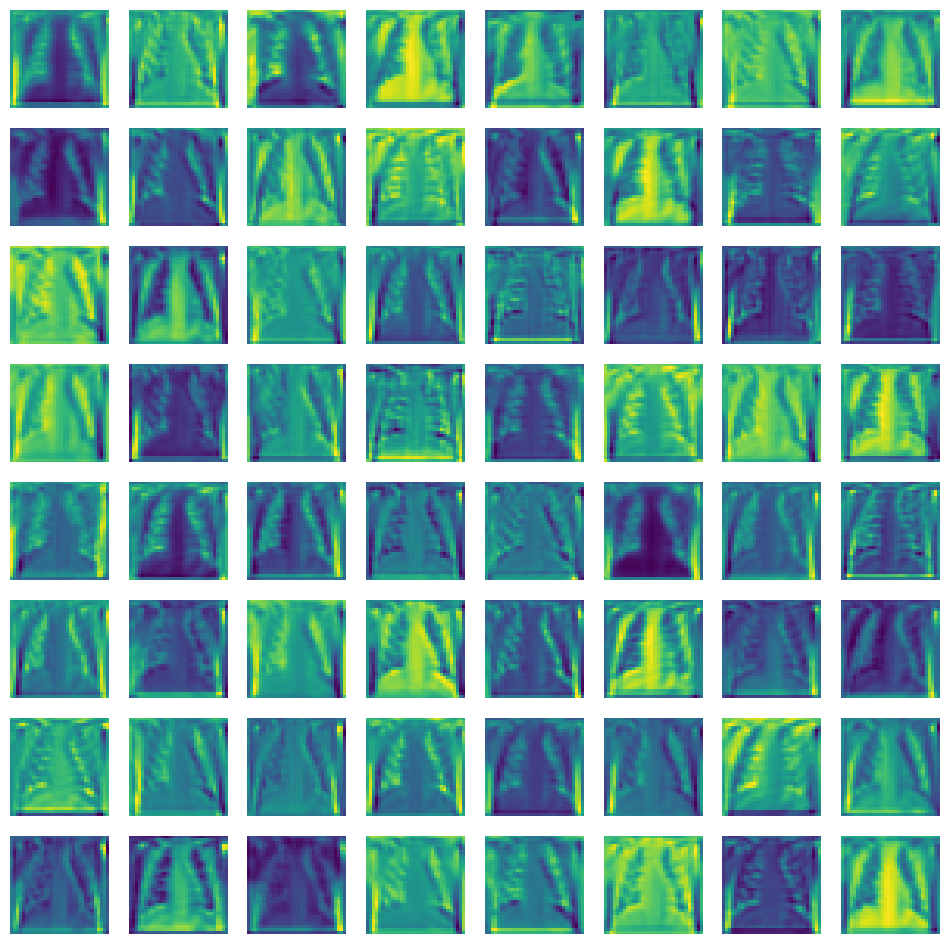

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Assuming you have a trained model
# model = tf.keras.models.load_model('your_model.h5')

# Choose the layers you want to visualize (e.g., all convolutional layers)
layer_names = [layer.name for layer in model.layers if 'conv' in layer.name or 'pool' in layer.name][:5]
layer_outputs = [model.get_layer(name).output for name in layer_names]

# Create a submodel that will return these outputs
visualization_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

image_path = 'D:\programing\Pneumonia\Images\Chest_xray\\2D\\train\PNEUMONIA\person1_bacteria_2.jpeg'

# You can also load an actual image, for example:
input_image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
input_image = tf.keras.preprocessing.image.img_to_array(input_image)
input_image = tf.expand_dims(input_image, axis=0)

# Get the feature maps
feature_maps = visualization_model(input_image)

# Visualize the feature maps
for layer_name, feature_map in zip(layer_names, feature_maps):
    print(f"Layer: {layer_name}")
    num_filters = feature_map.shape[-1]
    size = feature_map.shape[1]
    
    # Create a grid for visualization
    grid_size = int(num_filters ** 0.5)
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    
    for i in range(grid_size):
        for j in range(grid_size):
            if i * grid_size + j < num_filters:
                ax = axes[i, j]
                ax.imshow(feature_map[0, :, :, i * grid_size + j], cmap='viridis')
                ax.axis('off')
    
    plt.show()

## 3D

In [9]:
# class StereoscopicLayer(tf.keras.layers.Layer):
#     def __init__(self, shift_pixels=5, brightness_factor=1.5, **kwargs):
#         super(StereoscopicLayer, self).__init__(**kwargs)
#         self.shift_pixels = shift_pixels
#         self.brightness_factor = brightness_factor

#     def call(self, inputs):
#         # Shift the image horizontally by a few pixels to simulate depth
#         shifted_image = tf.roll(inputs, shift=self.shift_pixels, axis=2)  # Axis 2 is width

#         # Convert to red and cyan channels
#         # Ensure input tensor has 4D shape (batch_size, height, width, channels)
#         red_img = tf.image.rgb_to_grayscale(inputs)
#         red_img = tf.concat([red_img, tf.zeros_like(red_img), tf.zeros_like(red_img)], axis=-1)

#         cyan_img = tf.image.rgb_to_grayscale(shifted_image)
#         cyan_img = tf.concat([tf.zeros_like(cyan_img), cyan_img, cyan_img], axis=-1)

#         # Ensure the images are stacked correctly
#         stacked_images = tf.stack([red_img, cyan_img], axis=0)

#         # Compute the mean image
#         blend = tf.reduce_mean(stacked_images, axis=0)

#         # Adjust brightness
#         image_3d = tf.image.adjust_brightness(blend, delta=self.brightness_factor - 1.0)
#         return image_3d 


In [10]:
import tensorflow as tf

class StereoscopicLayer(tf.keras.layers.Layer):
    def __init__(self, shift_pixels=5, brightness_factor=1.5, sharpness_weight=0.7, **kwargs):
        super(StereoscopicLayer, self).__init__(**kwargs)
        self.shift_pixels = shift_pixels
        self.brightness_factor = brightness_factor
        self.sharpness_weight = sharpness_weight

    def call(self, inputs):
        # Shift the image horizontally by a few pixels to simulate depth
        shifted_image = tf.roll(inputs, shift=self.shift_pixels, axis=2)  # Axis 2 is width

        # Convert to red and cyan channels
        red_img = tf.image.rgb_to_grayscale(inputs)
        red_img = tf.concat([red_img, tf.zeros_like(red_img), tf.zeros_like(red_img)], axis=-1)

        cyan_img = tf.image.rgb_to_grayscale(shifted_image)
        cyan_img = tf.concat([tf.zeros_like(cyan_img), cyan_img, cyan_img], axis=-1)

        # Weighted blend of the red and cyan images to retain more sharpness
        blend = self.sharpness_weight * inputs + (1 - self.sharpness_weight) * (red_img + cyan_img) / 2.0

        # Adjust brightness
        image_3d = tf.image.adjust_brightness(blend, delta=self.brightness_factor - 1.0)

        return image_3d


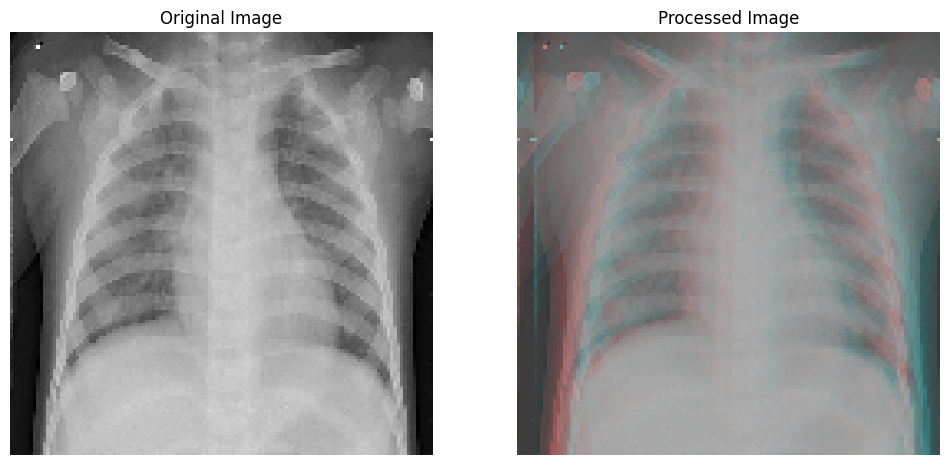

In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as keras_image

# Load a sample image
def load_image(image_path, target_size=(128, 128)):
    img = keras_image.load_img(image_path, target_size=target_size)
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return img_array

# Path to the image file
image_path = 'D:\programing\Pneumonia\Images\Chest_xray\\2D\\train\PNEUMONIA\person1_bacteria_2.jpeg'

# Load the image
image = load_image(image_path)

# Create the StereoscopicLayer instance
stereo_layer = StereoscopicLayer(shift_pixels=5, brightness_factor=1.2, sharpness_weight=0.2)

# Apply the layer
processed_image = stereo_layer(tf.convert_to_tensor(image, dtype=tf.float32))

# Convert processed image back to numpy array
processed_image_np = processed_image.numpy().squeeze()

# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original image
axes[0].imshow(image.squeeze())
axes[0].set_title('Original Image')
axes[0].axis('off')

# Processed image
axes[1].imshow(processed_image_np)
axes[1].set_title('Processed Image')
axes[1].axis('off')

plt.show()


In [12]:
# Example usage in a Keras model
def resnet_block(input, filters, strides=1):
    x = tf.keras.layers.Conv2D(filters, kernel_size=3, strides=strides, padding='same', use_bias=False)(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if strides != 1 or input.shape[-1] != filters:
        input = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same', use_bias=False)(input)
        input = tf.keras.layers.BatchNormalization()(input)

    x = tf.keras.layers.add([x, input])
    x = tf.keras.layers.ReLU()(x)
    return x

def resnet18(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = StereoscopicLayer()(inputs)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = resnet_block(x, 64)
    x = resnet_block(x, 64)

    x = resnet_block(x, 128, strides=2)
    x = resnet_block(x, 128)

    x = resnet_block(x, 256, strides=2)
    x = resnet_block(x, 256)

    x = resnet_block(x, 512, strides=2)
    x = resnet_block(x, 512)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs, outputs)
    return model

# Example usage
input_shape = (128, 128, 3)  # Modify based on your data shape
num_classes = 1  # Modify based on your number of classes

model = resnet18(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [13]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 stereoscopic_layer_1 (Stereosc  (None, 128, 128, 3)  0          ['input_2[0][0]']                
 opicLayer)                                                                                       
                                                                                                  
 conv2d_20 (Conv2D)             (None, 64, 64, 64)   9408        ['stereoscopic_layer_1[0][0]']   
                                                                                            

In [14]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20
)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc}")

Epoch 1/20
198/198 [==============================] - 18s 74ms/step - loss: 0.1586 - accuracy: 0.9395 - val_loss: 0.1722 - val_accuracy: 0.9252
Epoch 2/20
198/198 [==============================] - 14s 70ms/step - loss: 0.0752 - accuracy: 0.9742 - val_loss: 0.1518 - val_accuracy: 0.9506
Epoch 3/20
198/198 [==============================] - 14s 70ms/step - loss: 0.0478 - accuracy: 0.9824 - val_loss: 0.1360 - val_accuracy: 0.9531
Epoch 4/20
198/198 [==============================] - 14s 68ms/step - loss: 0.0322 - accuracy: 0.9889 - val_loss: 0.1256 - val_accuracy: 0.9607
Epoch 5/20
198/198 [==============================] - 14s 69ms/step - loss: 0.0240 - accuracy: 0.9924 - val_loss: 0.5888 - val_accuracy: 0.8657
Epoch 6/20
198/198 [==============================] - 14s 68ms/step - loss: 0.0250 - accuracy: 0.9918 - val_loss: 0.2731 - val_accuracy: 0.9379
Epoch 7/20
198/198 [==============================] - 14s 68ms/step - loss: 0.0247 - accuracy: 0.9908 - val_loss: 0.3567 - val_accuracy:

Layer: conv2d_20


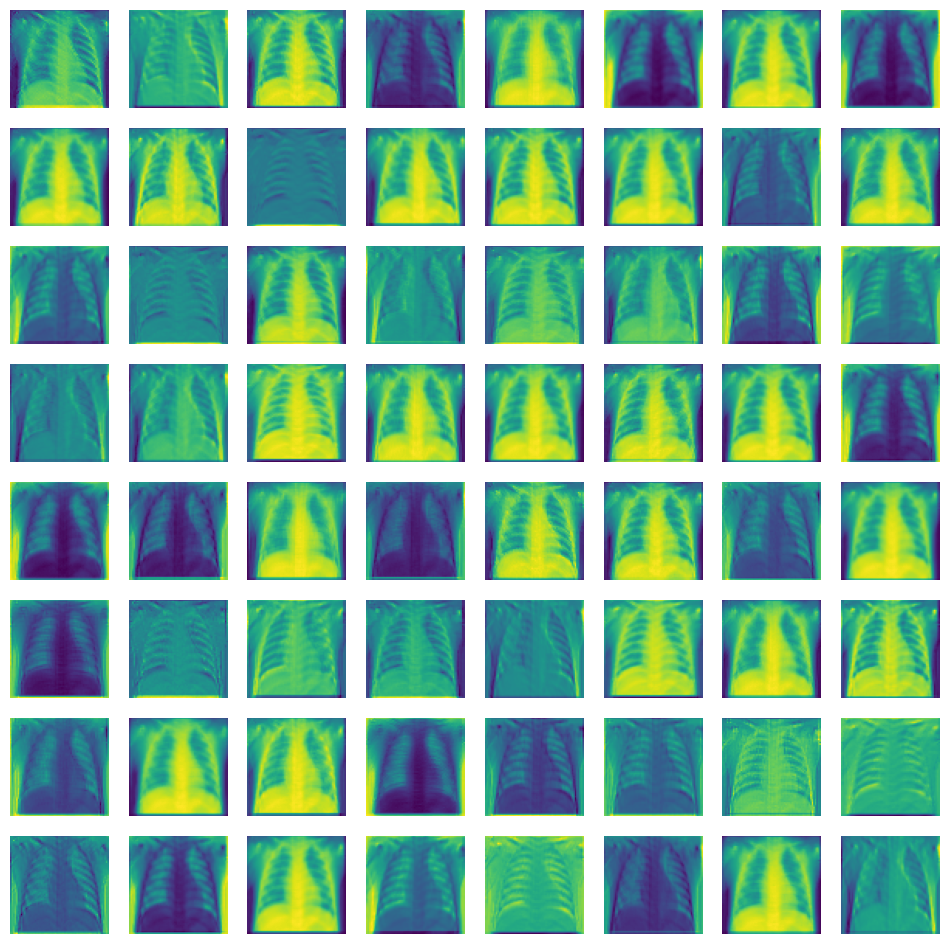

Layer: max_pooling2d_1


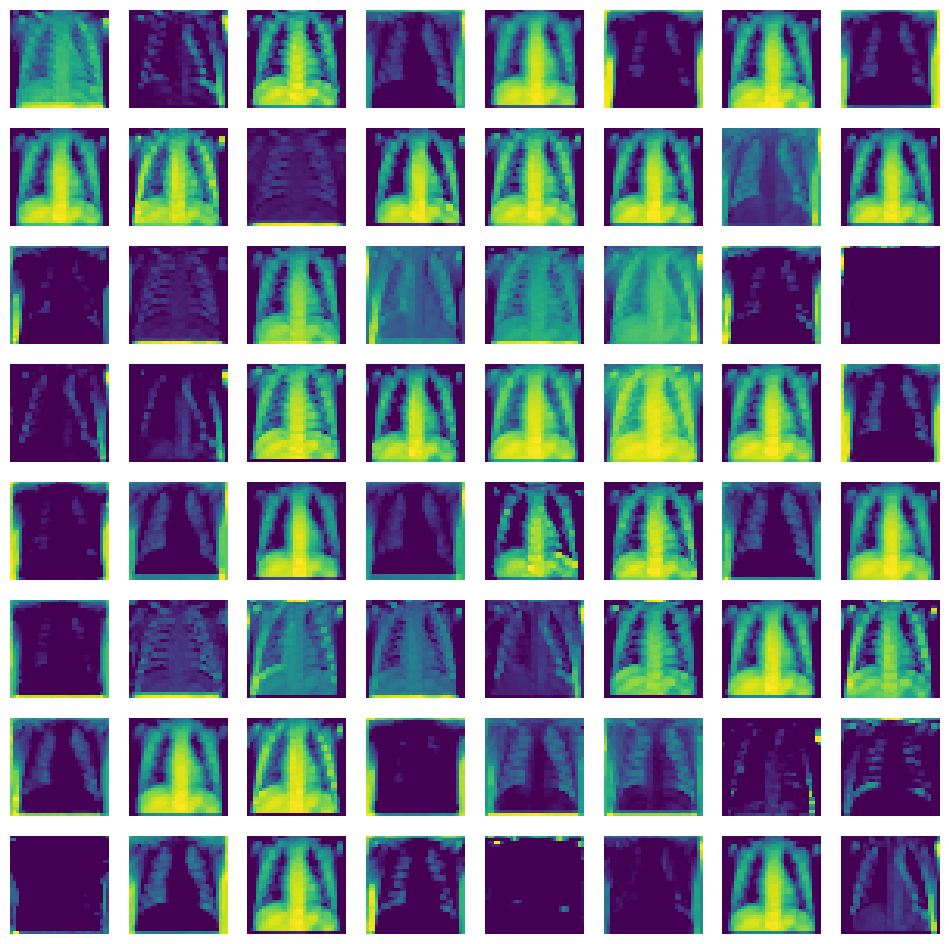

Layer: conv2d_21


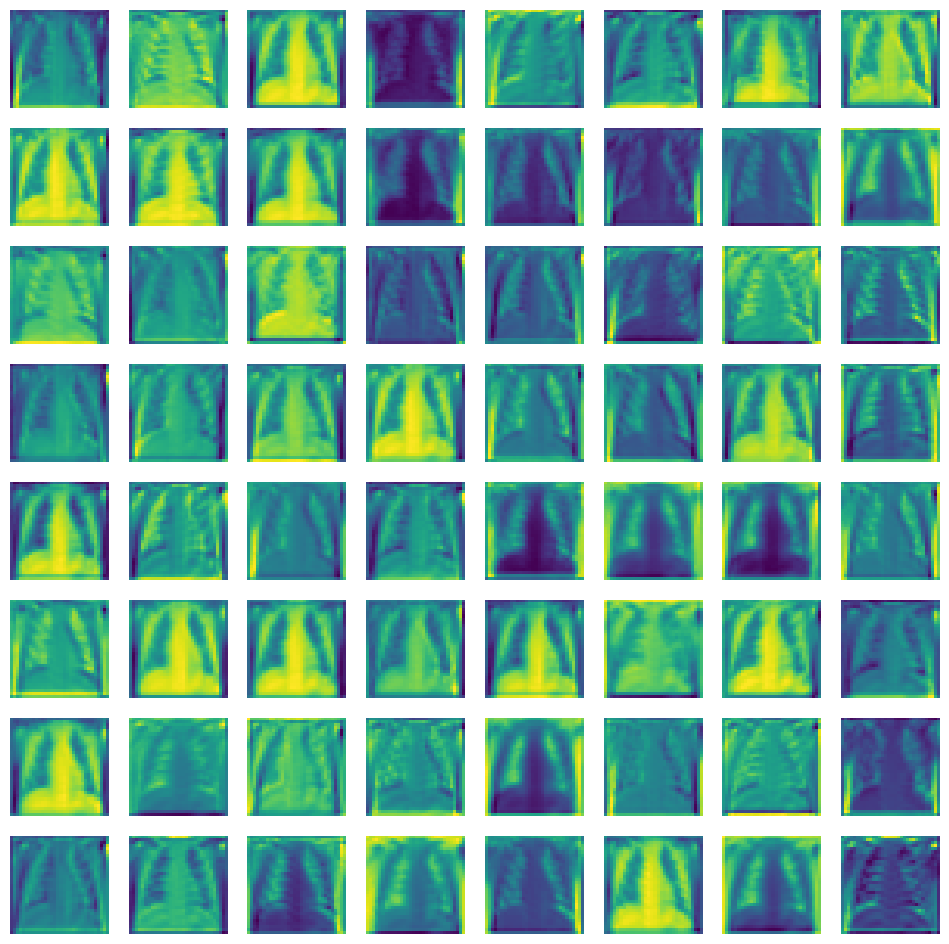

Layer: conv2d_22


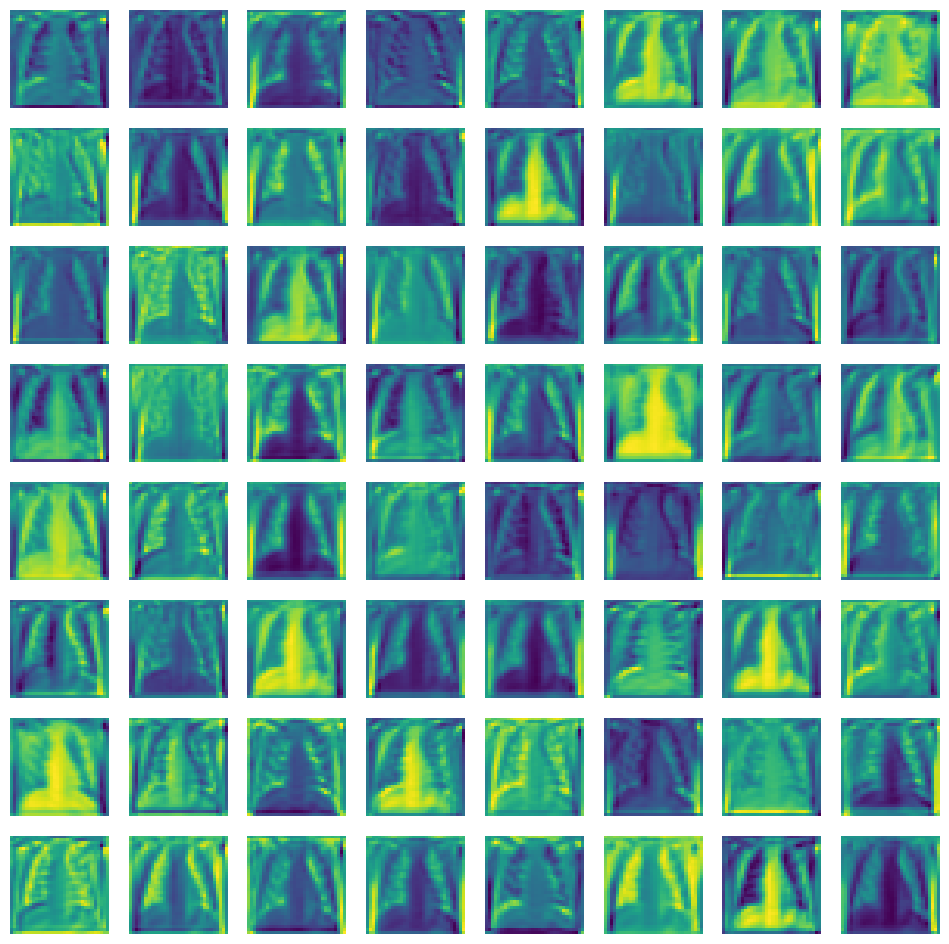

Layer: conv2d_23


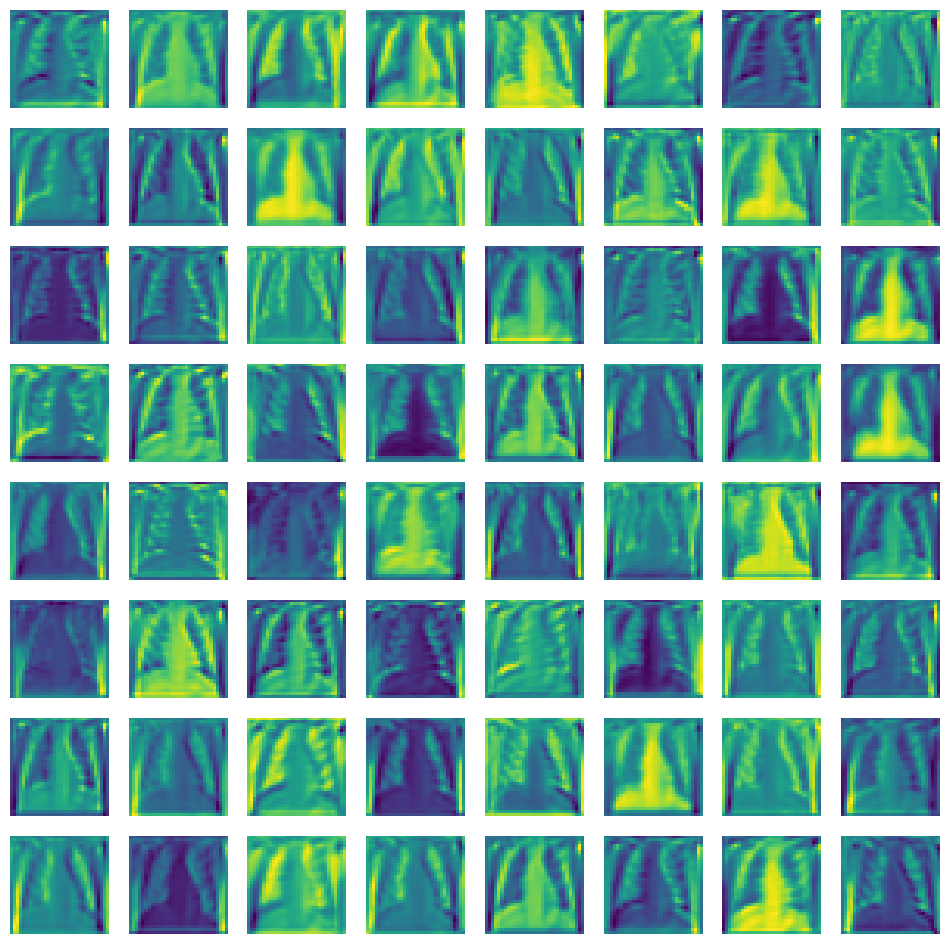

In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Assuming you have a trained model
# model = tf.keras.models.load_model('your_model.h5')

# Choose the layers you want to visualize (e.g., all convolutional layers)
layer_names = [layer.name for layer in model.layers if 'conv' in layer.name or 'pool' in layer.name][:5]
layer_outputs = [model.get_layer(name).output for name in layer_names]

# Create a submodel that will return these outputs
visualization_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

# You can also load an actual image, for example:
input_image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
input_image = tf.keras.preprocessing.image.img_to_array(input_image)
input_image = tf.expand_dims(input_image, axis=0)

# Get the feature maps
feature_maps = visualization_model(input_image)

# Visualize the feature maps
for layer_name, feature_map in zip(layer_names, feature_maps):
    print(f"Layer: {layer_name}")
    num_filters = feature_map.shape[-1]
    size = feature_map.shape[1]
    
    # Create a grid for visualization
    grid_size = int(num_filters ** 0.5)
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    
    for i in range(grid_size):
        for j in range(grid_size):
            if i * grid_size + j < num_filters:
                ax = axes[i, j]
                ax.imshow(feature_map[0, :, :, i * grid_size + j], cmap='viridis')
                ax.axis('off')
    
    plt.show()
